In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import config_readwrite as crw
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt

from scipy import stats
from scipy.stats import zscore, boxcox

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

CL = "HEPG2"
DATA = config["mpra"][f'{CL}.clean.transformed'] 

# load cl-specific elements
ENCODE = f"/wynton/group/ahituv/data/encode/{CL.lower()}/all_CTCF_dELS_pELS_PLS.bed"#all_CTCF_DELS_PELS_PLS.bed"

RESULTS = config["path"]["results"]
BED = "/wynton/group/ahituv/fongsl/projects/US/data/genome_loci/tiles.bed"


RE = os.path.join(RESULTS, "encode")
RE_CL = os.path.join(RE, CL)

# make the results
for dirname in [RE, RE_CL]:
    if os.path.exists(dirname) is False:
        os.mkdir(dirname)


# change directory 
os.chdir(RE_CL)

In [3]:
encode = pd.read_csv(ENCODE, sep='\t', header=None)
encode.groupby(9)[0].count()

9
CTCF-only,CTCF-bound    20944
PLS                     13597
PLS,CTCF-bound           2377
dELS                    25435
dELS,CTCF-bound          2947
pELS                    16656
pELS,CTCF-bound          2613
Name: 0, dtype: int64

## intersect genome library with ENCODE

# library

In [4]:
LIB_ENCODE = os.path.join(RE_CL, f"US_MPRA_LIB_x_{CL}_cCRE.tsv")

In [5]:
if os.path.exists(LIB_ENCODE) is False:
    
    # do pybedtool intersection
    lib = pbt.BedTool(BED)

    encode = pbt.BedTool(ENCODE)

    lib_encode = lib.intersect(encode, wao=True, output=LIB_ENCODE)


In [6]:
usecols = [0,1,2,3,7,13,15]
names=["#chr", "start", "end", "name",  "cCRE_accession", "cCRE", "overlap_bp"]
df = pd.read_csv(LIB_ENCODE, sep='\t',  header=None, 
                 names=names,
                usecols=usecols
                )
df["name_label"]=df["name"].apply(lambda x: x.split("_")[0])
df.head()

,#chr,start,end,name,cCRE_accession,cCRE,overlap_bp,name_label
0,chr3,29837526,29837795,bj_k27ac_down_chr3:29837526-29837795,.,.,0,bj
1,chr3,29837260,29837529,bj_k27ac_down_chr3:29837260-29837529,.,.,0,bj
2,chr3,29837792,29838061,bj_k27ac_down_chr3:29837792-29838061,.,.,0,bj
3,chr3,29837392,29837661,bj_k27ac_down_chr3:29837392-29837661,.,.,0,bj
4,chr3,29837659,29837928,bj_k27ac_down_chr3:29837659-29837928,.,.,0,bj


## filter df for CL-specific ATAC/H3k27AC sequences

In [7]:
df = df.loc[df['name'].str.contains(CL.lower())]

## separate overlapping from non-overlapping

In [8]:
OVERLAP = 1

In [9]:
# separate
notzero = df.loc[df["overlap_bp"]>=OVERLAP].copy()
zeros = df.loc[df["overlap_bp"]<OVERLAP].copy()

# count zero overlaps
zeros.groupby('name_label').count()

,#chr,start,end,name,cCRE_accession,cCRE,overlap_bp
name_label,,,,,,,
Neg,47,47,47,47,47,47,47
hepg2,4498,4498,4498,4498,4498,4498,4498


In [10]:
# non-zero overlap count
notzero.groupby('name_label').count()

,#chr,start,end,name,cCRE_accession,cCRE,overlap_bp
name_label,,,,,,,
Neg,20,20,20,20,20,20,20
hepg2,1801,1801,1801,1801,1801,1801,1801


# MPRA

## load MPRA data

In [11]:
mpra = pd.read_csv(DATA, sep='\t')
mpra

,seq.id,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,...,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean
0,seq.0,BJ_down-DEG-prom_ENSG00000258064_chr12:7167269...,Promoter_DEG,1.070365,0,1.107709,1.062185,1.041201,1.083715,0,...,0.138128,0.101153,0.087035,0.097621,0.045596,0.108409,0.115896,0.019592,0.021374,0.018276
1,seq.1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167293...,Promoter_DEG,1.127867,0,1.121452,1.154453,1.107696,1.119848,0,...,0.176313,0.136387,0.165367,0.173380,0.030620,0.176313,0.163178,0.023204,0.010945,-0.010201
2,seq.2,BJ_down-DEG-prom_ENSG00000258064_chr12:7167318...,Promoter_DEG,1.045273,0,1.060571,1.040215,1.035032,1.046512,0,...,0.049738,0.063808,0.056882,0.063799,0.018576,0.063808,0.065525,0.016711,0.006926,0.001725
3,seq.3,BJ_down-DEG-prom_ENSG00000258064_chr12:7167342...,Promoter_DEG,1.388219,1,1.431877,1.349455,1.383327,1.418199,1,...,0.536480,0.474277,0.468142,0.472809,0.042956,0.500746,0.503834,0.031216,0.032604,0.031026
4,seq.4,BJ_down-DEG-prom_ENSG00000258064_chr12:7167367...,Promoter_DEG,1.098010,0,1.121973,1.074758,1.097298,1.103948,0,...,0.127767,0.095960,0.133955,0.134668,0.031019,0.127767,0.141982,0.054537,-0.006189,0.007313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58612,seq.82411,k562_k27ac_up_chr9:129402570-129402839,Differential_H3K27ac,0.617967,0,0.577024,0.583477,0.693402,0.684918,0,...,-0.552846,-0.666423,-0.777253,-0.699596,0.148618,-0.552846,-0.549269,0.118982,0.224407,0.150326
58613,seq.82417,k562_k27ac_up_chrX:154123331-154123600,Differential_H3K27ac,1.118351,0,1.562728,0.924180,0.868144,1.154907,0,...,0.044281,0.049939,-0.113753,0.108773,0.465769,0.049939,0.192641,0.252084,0.163692,0.083868
58614,seq.82418,k562_k27ac_up_chrX:154123463-154123732,Differential_H3K27ac,0.963361,0,0.911258,1.057504,0.921321,0.938231,0,...,0.018573,-0.014789,-0.118224,-0.057210,0.119664,-0.014789,-0.098928,0.175419,0.103435,-0.041718
58615,seq.82421,k562_k27ac_up_chrX:154123863-154124132,Differential_H3K27ac,0.911969,0,0.897749,1.138903,0.699253,0.776374,0,...,-0.027868,-0.426472,-0.155616,-0.161361,0.351914,-0.426472,-0.393769,0.350695,-0.270856,-0.232408


In [12]:
mpra = pd.merge(df, mpra)  # merge encode library overlaps w/ MPRA data

# ENCODE bool overlap column
mpra["encode"] = False 
mpra.loc[mpra["cCRE"]!=".", "encode"] = True
mpra.loc[mpra["name"].str.contains("shuf"), "encode"] = "shuffle"

mpra.head()

,#chr,start,end,name,cCRE_accession,cCRE,overlap_bp,name_label,seq.id,label,...,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,encode
0,chr9,21084556,21084825,hepg2_k27ac_down_chr9:21084556-21084825,.,.,0,hepg2,seq.49882,Differential_H3K27ac,...,0.196352,0.272441,0.270030,0.065551,0.233799,0.230450,0.032553,-0.038642,-0.039580,False
1,chr9,21084290,21084559,hepg2_k27ac_down_chr9:21084290-21084559,.,.,0,hepg2,seq.49880,Differential_H3K27ac,...,-1.108851,-1.284402,-1.246266,0.194914,-1.286882,-1.273373,0.158200,-0.002481,-0.027107,False
2,chr9,21084822,21085091,hepg2_k27ac_down_chr9:21084822-21085091,.,.,0,hepg2,seq.49884,Differential_H3K27ac,...,0.153789,0.180951,0.127174,0.095441,0.153789,0.168301,0.047637,-0.027162,0.041126,False
3,chr9,21084422,21084691,hepg2_k27ac_down_chr9:21084422-21084691,.,.,0,hepg2,seq.49881,Differential_H3K27ac,...,0.168333,0.296880,0.327725,0.143800,0.168333,0.159278,0.049099,-0.128547,-0.168448,False
4,chr9,21084689,21084958,hepg2_k27ac_down_chr9:21084689-21084958,.,.,0,hepg2,seq.49883,Differential_H3K27ac,...,0.110939,0.120337,0.122447,0.052891,0.120329,0.129104,0.023799,-0.000008,0.006657,False


In [13]:
# what is the origin of elements that overlap cCRE?
mpra.groupby(["encode"])["#chr"].count()/mpra.groupby(["encode"])["#chr"].count().sum()

encode
False      0.734401
True       0.260961
shuffle    0.004637
Name: #chr, dtype: float64

In [14]:
# total CL MPRA
mpra.groupby(["encode"])["#chr"].count().sum()

4744

## directional consistency? 

In [15]:
# expected direction from ATAC/H3K27ac
mpra["exp_dir"] = "down"
mpra.loc[mpra['name'].str.contains("up"), "exp_dir"] = "up"
mpra.loc[mpra['name'].str.contains("down"), "exp_dir"] = "down"

# obs direction from delta.mean
mpra["obs_dir"] = "down"
mpra.loc[mpra["delta.mean"]>0, "obs_dir"] = "up"
mpra.loc[mpra["delta.mean"]<=0,"obs_dir"] = "down"


 l2.ratio.mean.ctrl 
exp_dir, True v. False MannwhitneyuResult(statistic=2458806.0, pvalue=1.81064264954679e-08)

 l2.ratio.mean.ctrl 
obs_dir, True v. False MannwhitneyuResult(statistic=2879332.0, pvalue=0.15901078402851831)
exp_dir         down                       up            
obs_dir         down           up        down          up
count    1400.000000  1404.000000  948.000000  992.000000
mean        0.018954     0.037440   -0.047473    0.008620
std         0.489349     0.439365    0.450395    0.372110
min        -2.137113    -2.076555   -2.338003   -2.018306
25%        -0.227974    -0.135345   -0.272170   -0.098075
50%         0.127456     0.160947    0.099469    0.120984
75%         0.335996     0.298376    0.251403    0.229647
max         1.535966     2.407402    1.072726    0.733974

 l2.ratio.mean.us 
exp_dir, True v. False MannwhitneyuResult(statistic=2499707.0, pvalue=2.061607376236314e-06)

 l2.ratio.mean.us 
obs_dir, True v. False MannwhitneyuResult(statistic=3526398.

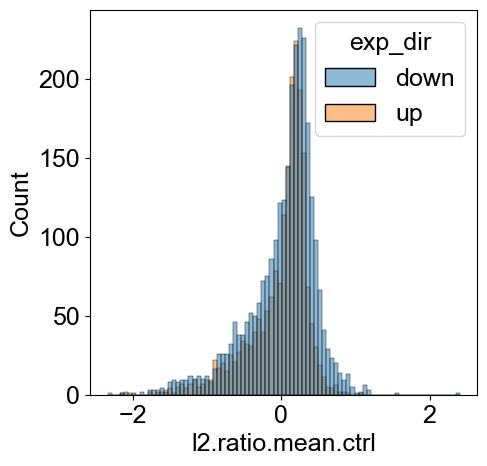

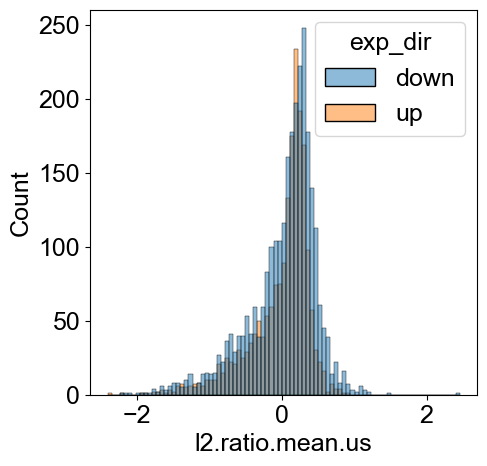

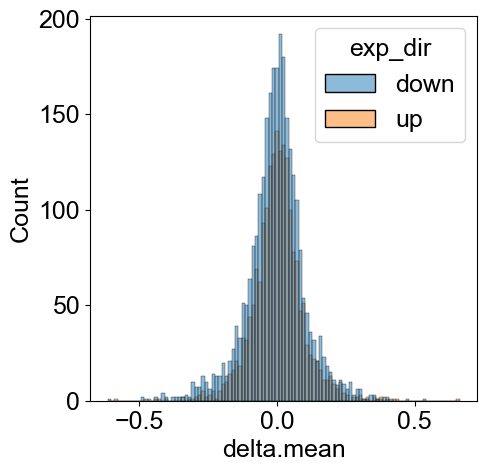

In [16]:
xs = ["l2.ratio.mean.ctrl", "l2.ratio.mean.us", "delta.mean"]
for var in xs:
    a = mpra.loc[mpra["exp_dir"] == "up", var]
    b = mpra.loc[mpra["exp_dir"] == "down", var]
    c = mpra.loc[mpra["obs_dir"] == "up", var]
    d = mpra.loc[mpra["obs_dir"] == "down", var]

    
    print("\n", var, "\nexp_dir, True v. False", stats.mannwhitneyu(a, b))
    print("\n", var, "\nobs_dir, True v. False", stats.mannwhitneyu(c, d))
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.histplot(x=var, data=mpra, hue="exp_dir")
    
    print(mpra.groupby(["exp_dir", "obs_dir"])[var].describe().T)

## violinplots


 l2.ratio.mean.ctrl 
True v. False MannwhitneyuResult(statistic=2300482.0, pvalue=0.0004790568352573942)

 True v. shuffle MannwhitneyuResult(statistic=16717.0, pvalue=0.06702215381692574)

 False v. shuffle MannwhitneyuResult(statistic=45165.0, pvalue=0.14837160933182958)
encode        False         True    shuffle
count   3484.000000  1238.000000  22.000000
mean       0.002031     0.030039  -0.073523
std        0.429713     0.486012   0.394243
min       -2.338003    -2.107659  -1.164124
25%       -0.170893    -0.183172  -0.182814
50%        0.125058     0.155477   0.067016
75%        0.267494     0.327144   0.137410
max        1.139565     2.407402   0.420731

 l2.ratio.mean.us 
True v. False MannwhitneyuResult(statistic=2295113.0, pvalue=0.0007741037854634579)

 True v. shuffle MannwhitneyuResult(statistic=16258.0, pvalue=0.11871020841994018)

 False v. shuffle MannwhitneyuResult(statistic=43814.0, pvalue=0.24610630585942883)
encode        False         True    shuffle
count   3484

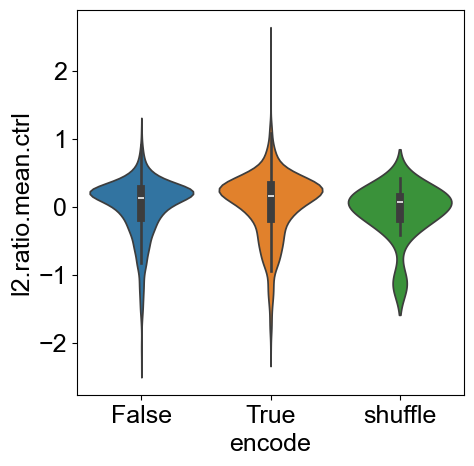

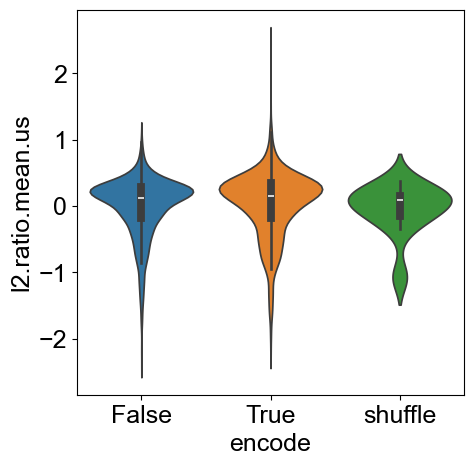

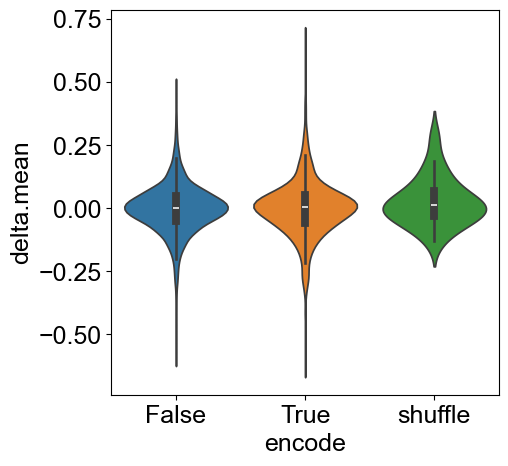

In [17]:
xs = ["l2.ratio.mean.ctrl", "l2.ratio.mean.us", "delta.mean"]
for y in xs:
    var = y
    fig, ax = plt.subplots(figsize=(5, 5))

    """sns.histplot(x=x, data=mpra, 
                 hue = "encode", 
                 color="blue", 
                 stat="percent", 
                 common_norm=False, 
                 kde=True
                )
    """
    sns.violinplot(x="encode",
                   y=var,
                   data=mpra,
                   palette="tab10"

                   )

    a = mpra.loc[mpra["encode"] == True, var]
    b = mpra.loc[mpra["encode"] == False, var]
    c = mpra.loc[mpra["encode"] == "shuffle", var]
    
    print("\n", var, "\nTrue v. False", stats.mannwhitneyu(a, b))
    print("\n True v. shuffle", stats.mannwhitneyu(a, c))
    print("\n False v. shuffle", stats.mannwhitneyu(b, c))

    print(mpra.groupby("encode")[var].describe().T)

## by cCRE

                       count  mean   std   min   25%   50%   75%   max
cCRE                                                                  
.                     3501.0  0.00  0.43 -2.34 -0.17  0.12  0.27  1.14
CTCF-only,CTCF-bound   450.0 -0.12  0.47 -1.87 -0.41  0.04  0.23  0.79
PLS                     37.0  0.01  0.69 -1.38 -0.39  0.06  0.40  2.41
PLS,CTCF-bound          10.0  0.06  0.48 -0.79  0.06  0.11  0.36  0.65
dELS                   525.0  0.13  0.46 -2.11 -0.07  0.23  0.39  1.54
dELS,CTCF-bound         94.0  0.00  0.51 -1.77 -0.34  0.17  0.33  1.02
pELS                   112.0  0.14  0.48 -1.75  0.03  0.21  0.36  1.20
pELS,CTCF-bound         15.0  0.09  0.27 -0.57  0.03  0.10  0.27  0.46
                       count  mean   std   min   25%   50%   75%   max
cCRE                                                                  
.                     3501.0  0.00  0.44 -2.41 -0.18  0.13  0.28  1.09
CTCF-only,CTCF-bound   450.0 -0.11  0.48 -1.91 -0.41  0.04  0.23  0.85
PLS   

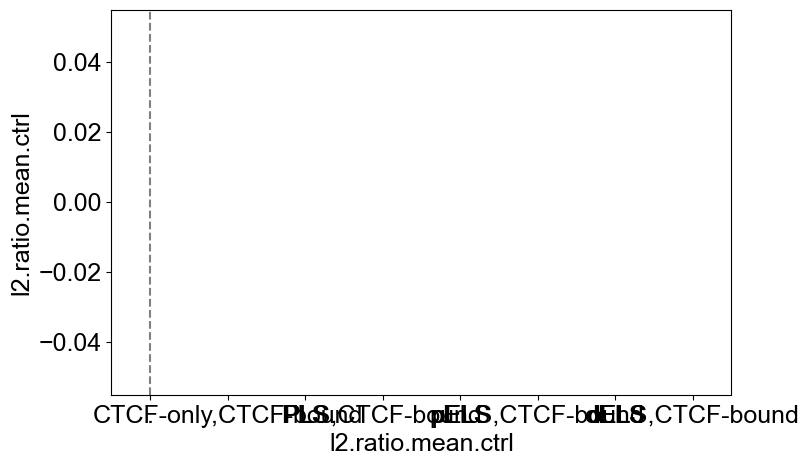

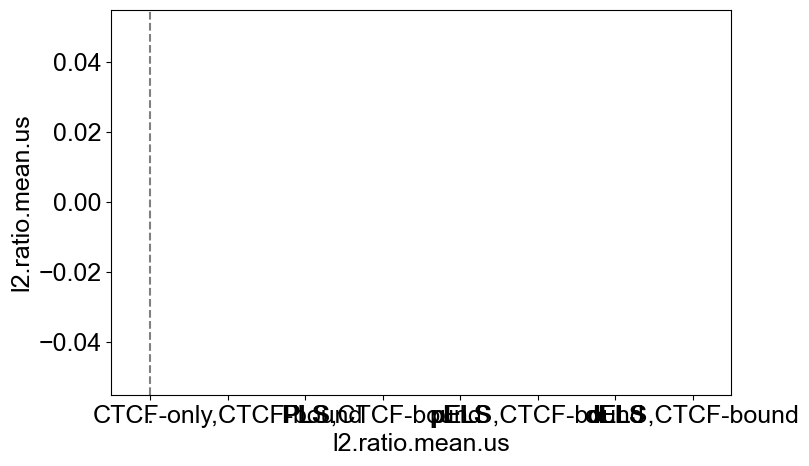

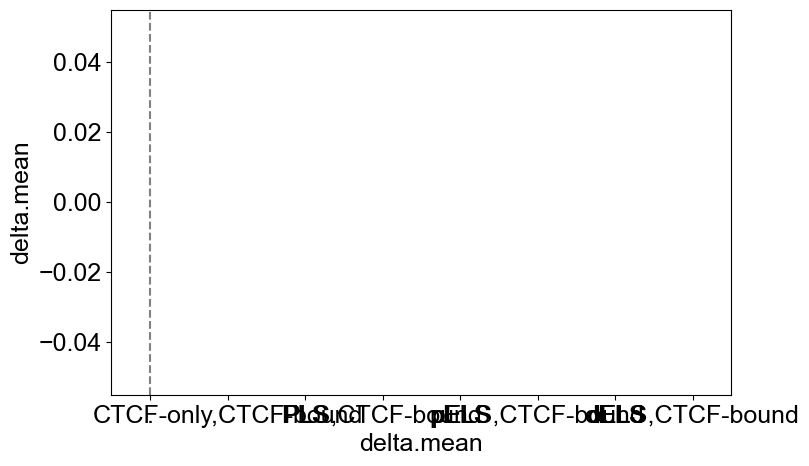

In [18]:
xs = ["l2.ratio.mean.ctrl", "l2.ratio.mean.us", "delta.mean"]
y='cCRE'
order=['.',
        'CTCF-only,CTCF-bound',
        'PLS',
        'PLS,CTCF-bound',
        'pELS',
        'pELS,CTCF-bound', 
        'dELS',
        'dELS,CTCF-bound'
              ]
for y in xs:
    var = y

    fig, ax = plt.subplots(figsize=(8, 5))

   
    sns.violinplot(x=y,
                   y=var,
                   order=order,
                   data=mpra,
                   palette="tab10",
                   split=True

                   )
    ax.axvline(0, ls="--", color="grey")

    print(mpra.groupby("cCRE")[var].describe().round(2))

In [19]:
print(mpra.groupby("cCRE")[var].describe().round(2))

                       count  mean   std   min   25%   50%   75%   max
cCRE                                                                  
.                     3501.0 -0.00  0.10 -0.59 -0.05  0.00  0.05  0.47
CTCF-only,CTCF-bound   450.0  0.00  0.12 -0.49 -0.06  0.00  0.06  0.53
PLS                     37.0 -0.00  0.20 -0.42 -0.07 -0.01  0.07  0.66
PLS,CTCF-bound          10.0 -0.04  0.12 -0.23 -0.15  0.02  0.04  0.08
dELS                   525.0 -0.01  0.10 -0.62 -0.05  0.00  0.04  0.43
dELS,CTCF-bound         94.0  0.00  0.10 -0.27 -0.06  0.01  0.05  0.26
pELS                   112.0  0.01  0.11 -0.30 -0.05  0.01  0.05  0.44
pELS,CTCF-bound         15.0  0.01  0.13 -0.11 -0.08 -0.01  0.03  0.39
